# Long-term Recurrent Convolutional Network

### Install all the necessary python packages

In [ ]:
!pip install pafy youtube-dl moviepy
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install scipy

### Import all necessary libraries

In [92]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

### Set the seed constant

The seed value is used to generate the random number generator. And, every time you use the same seed value, you will get the same random values.

In [93]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

### Get the names of all classes in dataset

In [94]:
all_classes_names = os.listdir('GMS')

### Visualize a random sample videos from the dataset for each category

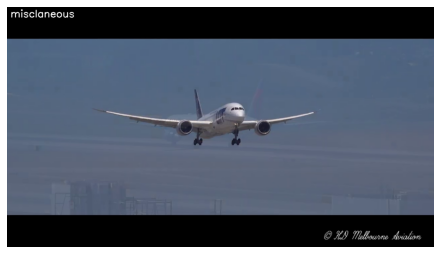

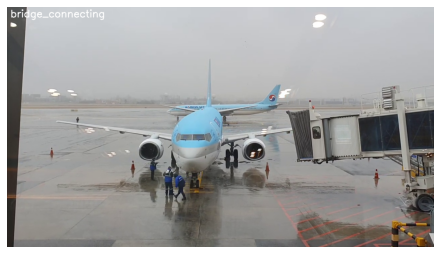

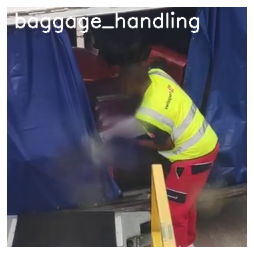

In [95]:
random_range = random.sample(range(len(all_classes_names)), 3)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'GMS/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'GMS/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    plt.figure(figsize=(15, 15))
    # Display the frame.
    plt.subplot(3, 1, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

### Data Preprocessing

Since we are going to use a classification architecture to train on a video classification dataset, we need to preprocess the dataset first.

This is the size we will resize all frames of the video to, we are doing this to avoid unnecessary computation.

In [53]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

Specify the number of frames of a video that will be fed to the model as one sequence.

In [96]:
SEQUENCE_LENGTH = 6

The path of the directory containing the extracted dataset.

In [97]:
DATASET_DIR = "GMS"

Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.

In [98]:
CLASSES_LIST = ["bridge_connecting", "baggage_handling", "misclaneous"]

This "frame_extraction" method takes a video file path as input. It then reads the video file frame by frame, resizes each frame, normalizes the resized frame, appends the normalized frame into a list, and then finally returns that list.

In [99]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

This "create_dataset" function will extract the data of the selected classes and create the required dataset. It return a list containing the extracted frames of the videos, list containing the indexes of the classes associated with the videos, and list containing the paths of the videos in the disk.

In [100]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Create the dataset by calling "create_dataset" function.

In [101]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: bridge_connecting
Extracting Data of Class: baggage_handling
Extracting Data of Class: misclaneous


Using Keras's to_categorical method to convert labels into one-hot-encoded vectors

In [102]:
one_hot_encoded_labels = to_categorical(labels)

In [103]:
len(one_hot_encoded_labels)

334

### Split the data into Train and Test Sets

Now we have two numpy arrays, one containing all images. The second one contains all class labels in one hot encoded format. Let us split our data to create a training, and a testing set. We must shuffle the data before the split, which we have already done.

In [104]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

In [105]:
len(labels_train)

250

In [106]:
len(labels_test)

84

In [107]:
count_baggage = 0
count_bridge = 0
count_mis = 0
for each in labels_train:
    if each[0] == 0. and each[1] == 1. and each[2] == 0.:
        count_baggage = count_baggage + 1
    if each[0] == 1. and each[1] == 0. and each[2] == 0.:
        count_bridge = count_bridge + 1
    if each[0] == 0. and each[1] == 0. and each[2] == 1.:
        count_mis = count_mis + 1
print(count_baggage)
print(count_bridge)
print(count_mis)

75
78
97


### Define the model

Let's create a "create_LRCN_model" function that will construct our model. Here, we will be using sequential model for model construction. 

### Model Architecture:

Uses time-distributed conv2D layers, which allows applying the same layer to every frame of the video independently. This layer can take input of shape (no_of_frames, width, height, num_of_channels). This is very beneficial as it allows to input the whole video into the model in a single shot. This layer is followed by MaxPooling2D and Dropout layers.  The spatial features extracted from the Conv2D layers will be flattened using Flatten layer. This flatten output is then passed onto LSTM layer. The output of LSTM layer is fed into the Dense layer with softmax activation which will be used to predict the action being performed. 

In [108]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Construct the required LRCN model:

In [109]:
LRCN_model = create_LRCN_model()
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_36 (TimeDi  (None, 6, 64, 64, 16)    448       
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 6, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 6, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 6, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 6, 4, 4, 32)     

Using the plot_model function, we can check the structure of the final model. This is really helpful when we are creating a complex network, and you want to make sure we have constructed the network correctly.

In [110]:
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

Create an Instance of Early Stopping Callback:

In [111]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

Compile the model and specify loss function, optimizer and metrics to the model:

In [112]:
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

### Model training

In [113]:
LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True,
                                             validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/70
50/50 [==============================] - 3s 30ms/step - loss: 1.1128 - accuracy: 0.3650 - val_loss: 1.0750 - val_accuracy: 0.3800
Epoch 2/70
50/50 [==============================] - 1s 21ms/step - loss: 0.8256 - accuracy: 0.6300 - val_loss: 0.5835 - val_accuracy: 0.6800
Epoch 3/70
50/50 [==============================] - 1s 21ms/step - loss: 0.4919 - accuracy: 0.7050 - val_loss: 0.4798 - val_accuracy: 0.6800
Epoch 4/70
50/50 [==============================] - 1s 20ms/step - loss: 0.4471 - accuracy: 0.6800 - val_loss: 0.4549 - val_accuracy: 0.7000
Epoch 5/70
50/50 [==============================] - 1s 19ms/step - loss: 0.4160 - accuracy: 0.7300 - val_loss: 0.4640 - val_accuracy: 0.6800
Epoch 6/70
50/50 [==============================] - 1s 21ms/step - loss: 0.4458 - accuracy: 0.7250 - val_loss: 0.4818 - val_accuracy: 0.7000
Epoch 7/70
50/50 [==============================] - 1s 22ms/step - loss: 0.4735 - accuracy: 0.7000 - val_loss: 0.4748 - val_accuracy: 0.6800
Epoch 8/70
50

### Model Evaluation

In [114]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

3/3 [==============================] - 0s 24ms/step - loss: 0.4916 - accuracy: 0.8452


Get the loss and accuracy from model_evaluation_history.

In [115]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

You should now save your model for future runs.

In [116]:
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

### Model Inference

The "plot_metric" method get metrics value using metric names as identifiers and constructs a range object which will be used as time. This function plots the graph, adds title, and legend.

In [117]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

Visualize the training and validation loss metrices:

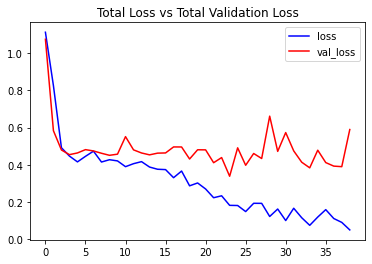

In [118]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

Visualize the training and validation accuracy metrices:

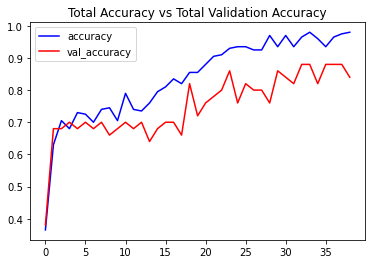

In [119]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')